In [2]:
import fastai
from fastai.vision import *

In [3]:
path = Path('.')

In [4]:
train = path/'train_dehaze/'
test =  path/'leaderboard_test_data_dehaze/'
holdout = path/'leaderboard_holdout_data_dehaze/'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'

In [5]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]

In [6]:
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

In [7]:
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [8]:
# df = df[df.score>0.85]

In [9]:
N = len(df); N

15244

In [60]:
def get_data(size=128, bs=64, pct=0.2, seed=2019, n_sample=len(df)):
    src = (ImageItemList.from_df(df.sample(n_sample), path, folder=train)
           .random_split_by_pct(pct, seed=seed)
           .label_from_df('has_oilpalm')
           .add_test(test_names+holdout_names))
    return (src.transform(get_transforms(flip_vert=True, max_lighting=0.5), size=size)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

In [13]:
#This was working perfectly some minutes ago!
from sklearn.metrics import roc_auc_score
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1])) # use as metric

def get_learner(data, arch=models.resnet50, mixup=True):
    learn = create_cnn(data, arch, 
                       metrics=[accuracy], 
                       model_dir='/kaggle/working/models')
    if mixup: learn.mixup()
    return learn.to_fp16()

In [14]:
data = get_data()

In [15]:
learn = get_learner(data)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 40179157.49it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


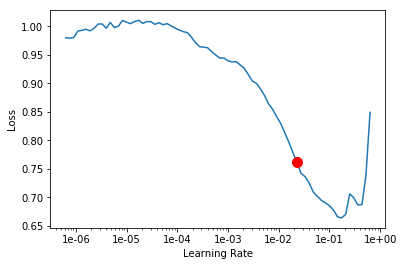

In [16]:
learn.lr_find(); learn.recorder.plot()

In [17]:
lr = 2e-2

In [18]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy
1,0.158028,0.054551,0.983596
2,0.139717,0.107515,0.958990
3,0.139721,0.058817,0.981299
4,0.137796,0.049380,0.985564
5,0.128637,0.085292,0.984580
6,0.118660,0.057117,0.981627
7,0.118598,0.044897,0.986549
8,0.111753,0.041149,0.990157
9,0.103237,0.046395,0.987533
10,0.098447,0.045196,0.987533


In [20]:
p,t = learn.get_preds()
auc_score(p,t)

tensor(0.9961)

In [21]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.104384,0.042851,0.986877
2,0.114874,0.050641,0.988189
3,0.110213,0.052417,0.988517
4,0.102008,0.047134,0.988189
5,0.098349,0.045934,0.988189
6,0.095575,0.045487,0.987533


In [22]:
p,t = learn.get_preds()
auc_score(p,t)

tensor(0.9967)

In [23]:
learn.save('128')

256

In [25]:
learn.data = get_data(256, 64, 0.01)
learn.freeze()
learn.fit_one_cycle(6, slice(1e-4))
learn.save('256')

epoch,train_loss,valid_loss,accuracy
1,0.111103,0.023989,1.000000
2,0.110584,0.023402,1.000000
3,0.112626,0.024779,1.000000
4,0.111710,0.024720,1.000000
5,0.106340,0.031416,0.993421
6,0.111774,0.023246,1.000000


In [26]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-5,1e-4))
learn.save('256u')

epoch,train_loss,valid_loss,accuracy
1,0.109784,0.123763,0.993421
2,0.103961,0.024135,1.000000
3,0.100619,0.019501,1.000000
4,0.102747,0.025943,1.000000
5,0.108150,0.023496,1.000000
6,0.100412,0.024036,1.000000


In [31]:
learn.to_fp16()
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [48]:
learn = get_learner(get_data(256, 64, 0.01))
learn.load('256u')
learn.model.float()
p,t = learn.TTA(ds_type=DatasetType.Test)

In [49]:
p = to_np(p); p.shape

(6534, 2)

In [50]:
preds = p[:,1]

# X-validation

In [ ]:
# sample = 500
f = open("log.txt","w+")
folds = 5
preds = 0
for i in range(folds):
    f.write(f'---Fold {i}---\n')
    data = get_data(256, 64, seed=i)
    learn = get_learner(data)
    learn.freeze()
    learn.fit_one_cycle(1, slice(1e-2))
    learn.save(f'256-{i}')
    learn.unfreeze()
    learn.fit_one_cycle(1, slice(1e-4,1e-3))
    learn.save(f'256u-{i}')
    p,t = learn.get_preds()
    f.write(f'  AUC score after fold {i} :{auc_score(p,t)}\n')
    
    #TTA shit
    learn = get_learner(get_data(256, 48))
    learn.load(f'256u-{i}')
    learn.model.float()
    p,t = learn.TTA(ds_type=DatasetType.Test)
    
    preds += to_np(p[:,1])/folds

epoch,train_loss,valid_loss,accuracy
1,0.138879,0.050546,0.982940


epoch,train_loss,valid_loss,accuracy


In [12]:
preds.shape

(6534,)

## Sub file

In [51]:
ids = np.array([f.name for f in test_names]+[f.name for f in holdout_names])

In [52]:
ids.shape

(6534,)

In [53]:
sub = pd.DataFrame(np.stack([ids, preds], axis=1), columns=df_sample.columns)

In [54]:
sub.to_csv('sub_resnet50_haze_TTA.csv', index=False)